In [1]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px

from pydataset import data
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_selection import RFE, SelectKBest, f_regression


import warnings
warnings.filterwarnings("ignore")


In [10]:
def univariate_explore(df):
    ''' 
    takes in dataframe, and puts out a histogram of each category, binning relatively low
    '''
    plt.figure(figsize=(25, 5))
    for i, col in enumerate(df.columns.tolist()): # List of columns
        plot_number = i + 1 # i starts at 0, but plot nos should start at 1
        plt.subplot(1,len(df.columns.tolist()), plot_number) # Create subplot.
        plt.title(col) # Title with column name.
        df[col].hist(bins=10) # Display histogram for column.
        plt.ylabel("Count")
        plt.grid(False) # Hide gridlines.
    plt.show()
    plt.title("Boxplot of continous features") # Title with column name.
    df.boxplot() # Display boxplot for column.
    plt.ylabel("Count")
    plt.grid(False) # Hide gridlines.

def plot_variable_pairs(df,num_vars):
    ''' 
    that accepts a dataframe and numerical variables as input and plots all of the 
    pairwise relationships along with the regression line for each pair.
    '''

    l=0
    plt.figure(figsize=(25, 25))
    for col1 in num_vars:
        for col2 in num_vars:
            if not num_vars.index(col2) >= num_vars.index(col1):
                l +=1
                x=df[col1]
                y=df[col2]

                plt.subplot(len(num_vars)-2,len(num_vars)-1,l)
                

                plt.plot(x, y, "o",color="grey")

                m,b = np.polyfit(x,y,1)
                plt.plot(x,m*x+b,label=f"regression line - f(x)={round(m,0)}x+{round(b,0)}")
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.legend()
                plt.title(f"{col2} value by {col1} value - {l}")
    plt.show()

    return

def get_outliers(df1, k):
   '''
    Given a series and a cutoff value, k (tukey value), returns the upper outliers for the series.
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound (q3 + (k*iqr)) the observation is.
   '''
   df=df1.copy()
   for col in df.describe().columns:
      if not col.endswith('_outlier'):
         q1, q3 = df[col].quantile([.25, .75])
         iqr = q3 - q1
         upper_bound = q3 + k * iqr
         lower_bound = q1 - k * iqr
         #print(col)
         df[f"{col}_outlier"] = np.where((df[col] - upper_bound) > 0,(df[col] - upper_bound),
                                       np.where((df[col] - lower_bound)<0,(df[col] - lower_bound),0))

   outlier_cols = [col for col in df if col.endswith('_outlier')]
   for col in outlier_cols:
      #print('~~~\n' + col)
      data = df[col][df[col] > 0]
      #print(data.describe())

   return df,outlier_cols

In [3]:
url = "https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv"
df = pd.read_csv(url)
df

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18
...,...,...,...,...,...,...,...
360,12/27/17,Wednesday,42.7,1.00,33,0.5,19
361,12/28/17,Thursday,37.8,1.25,32,0.5,16
362,12/29/17,Friday,39.5,1.25,17,0.5,15
363,12/30/17,Saturday,30.9,1.43,22,0.5,13


# Use the IQR Range Rule and the upper and lower bounds to identify the lower outliers of each column of lemonade.csv, using the multiplier of 1.5. Do these lower outliers make sense? Which outliers should be kept?

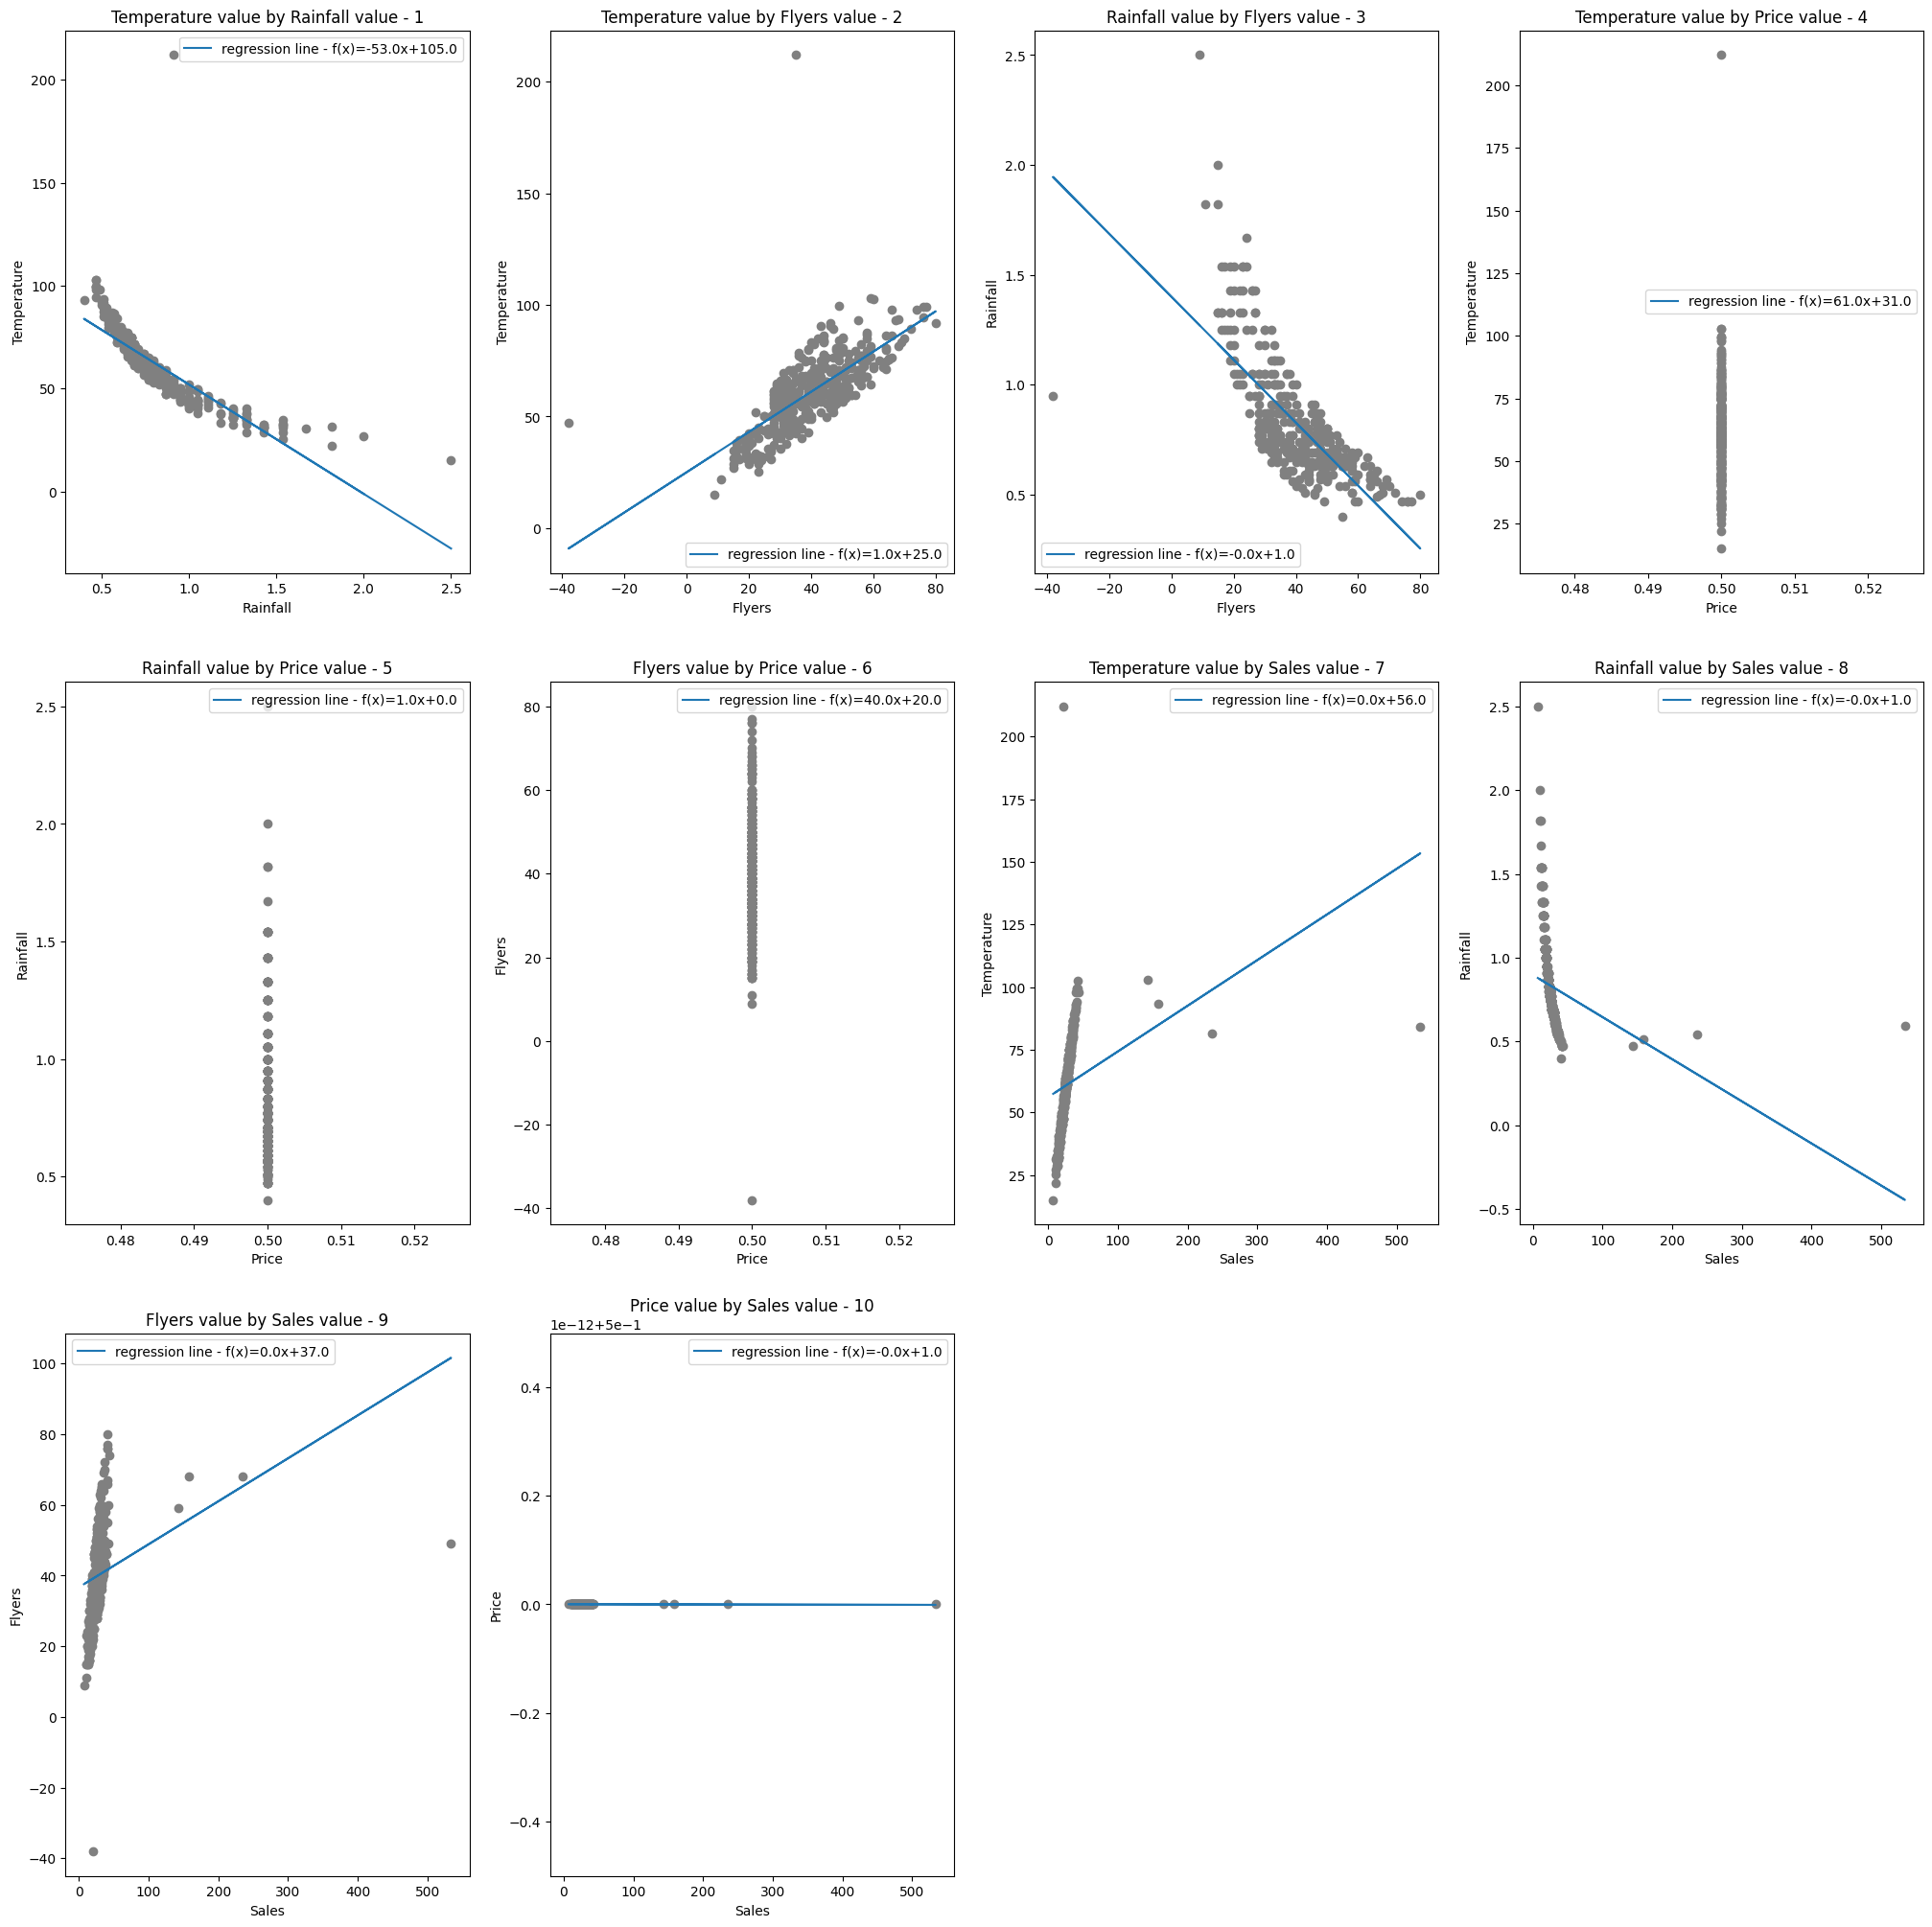

In [4]:
plot_variable_pairs(df,['Temperature','Rainfall','Flyers','Price','Sales'])

In [5]:
df1,out_list = get_outliers(df, k=1.5)
df1[df1[out_list].sum(axis=1) < 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0.0,0.0,-42.0,0.0,0.0
364,12/31/17,Sunday,15.1,2.50,9,0.5,7,-1.6,1.2,0.0,0.0,0.0


flyers looks to be an error, temperature is likely real  
drop flyers outlier

# Use the IQR Range Rule and the upper and upper bounds to identify the upper outliers of each column of lemonade.csv, using the multiplier of 1.5. Do these upper outliers make sense? Which outliers should be kept?

In [6]:
df1,out_list = get_outliers(df, k=1.5)
df1[df1[out_list].sum(axis=1) > 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0.0,0.70,0.0,0.0,0.0
1,1/2/17,Monday,28.9,1.33,15,0.5,13,0.0,0.03,0.0,0.0,0.0
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15,0.0,0.03,0.0,0.0,0.0
5,1/6/17,Friday,25.3,1.54,23,0.5,11,0.0,0.24,0.0,0.0,0.0
6,1/7/17,Saturday,32.9,1.54,19,0.5,13,0.0,0.24,0.0,0.0,0.0
10,1/11/17,Wednesday,32.6,1.54,23,0.5,12,0.0,0.24,0.0,0.0,0.0
11,1/12/17,Thursday,38.2,1.33,16,0.5,14,0.0,0.03,0.0,0.0,0.0
12,1/13/17,Friday,37.5,1.33,19,0.5,15,0.0,0.03,0.0,0.0,0.0
15,1/16/17,Monday,30.6,1.67,24,0.5,12,0.0,0.37,0.0,0.0,0.0
16,1/17/17,Tuesday,32.2,1.43,26,0.5,14,0.0,0.13,0.0,0.0,0.0


outlier of 200 degrees is likely a typo, can drop or change to impute to similar around time frame  
rainfall is likely real  
price... price never changes  
sales could remove outliers if trying to predict typical sales, 534 is highly irregular  
Keep outliers: price and rainfall  
drop outliers: temperature, flyers, sales

# Using the multiplier of 3, IQR Range Rule, and the lower bounds, identify the outliers below the lower bound in each colum of lemonade.csv. Do these lower outliers make sense? Which outliers should be kept?

In [7]:
df1,out_list = get_outliers(df, k=3)
df1[df1[out_list].sum(axis=1) < 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0.0,0.0,-15.0,0.0,0.0


these outliers do not make sense, they should not be kept

# Using the multiplier of 3, IQR Range Rule, and the upper bounds, identify the outliers above the upper_bound in each colum of lemonade.csv. Do these upper outliers make sense? Which outliers should be kept?

In [8]:
df1,out_list = get_outliers(df, k=3)
df1[df1[out_list].sum(axis=1) > 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0.0,0.31,0.0,0.0,0.0
41,2/11/17,Saturday,212.0,0.91,35,0.5,21,74.3,0.00,0.0,0.0,0.0
181,7/1/17,Saturday,102.9,0.47,59,0.5,143,0.0,0.00,0.0,0.0,83.0
182,7/2/17,Sunday,93.4,0.51,68,0.5,158,0.0,0.00,0.0,0.0,98.0
183,7/3/17,Monday,81.5,0.54,68,0.5,235,0.0,0.00,0.0,0.0,175.0
184,7/4/17,Tuesday,84.2,0.59,49,0.5,534,0.0,0.00,0.0,0.0,474.0
338,12/5/17,Tuesday,22.0,1.82,11,0.5,10,0.0,0.13,0.0,0.0,0.0
343,12/10/17,Sunday,31.3,1.82,15,0.5,11,0.0,0.13,0.0,0.0,0.0
364,12/31/17,Sunday,15.1,2.50,9,0.5,7,0.0,0.81,0.0,0.0,0.0


temperature is likely erroneous  
rainfall could be real  
sales would definitely need to be investigated and likely would be dropped if doing any type of  prediction on it

# Identify if any columns in lemonade.csv are normally distributed. For normally distributed columns:

Use a 2 sigma decision rule to isolate the outliers.

Do these make sense?
Should certain outliers be kept or removed?

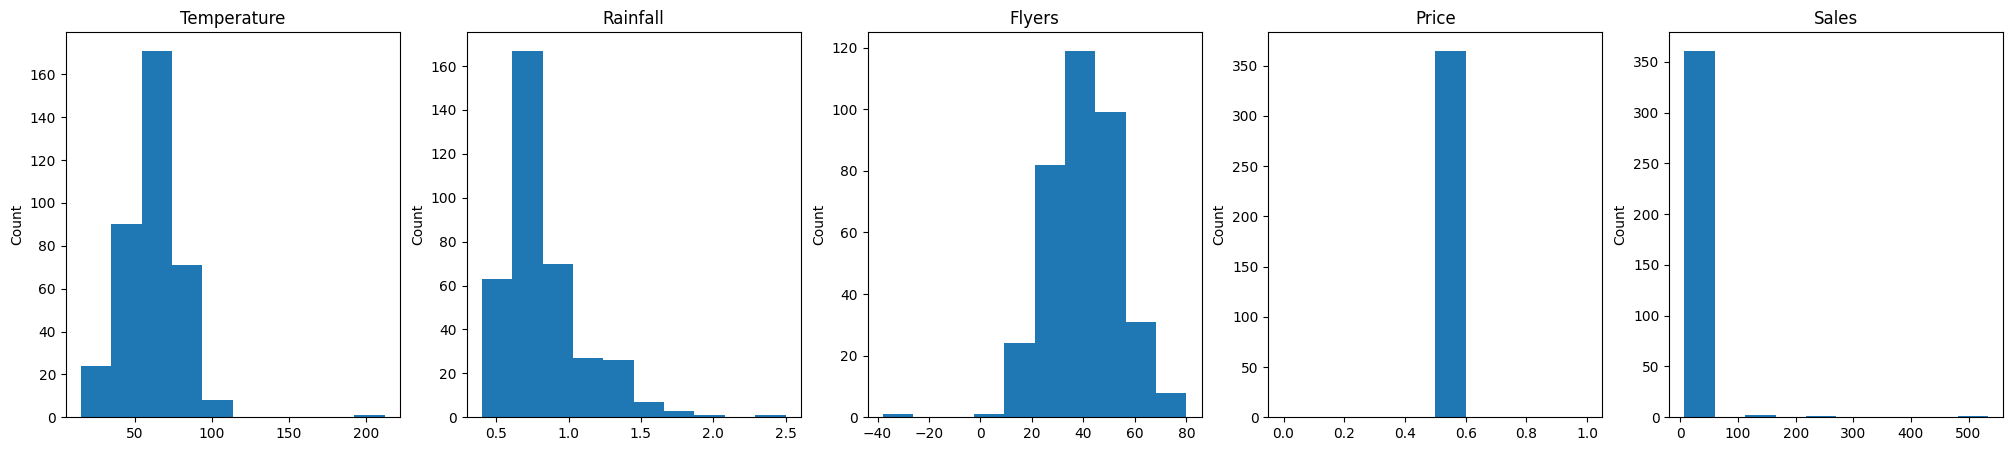

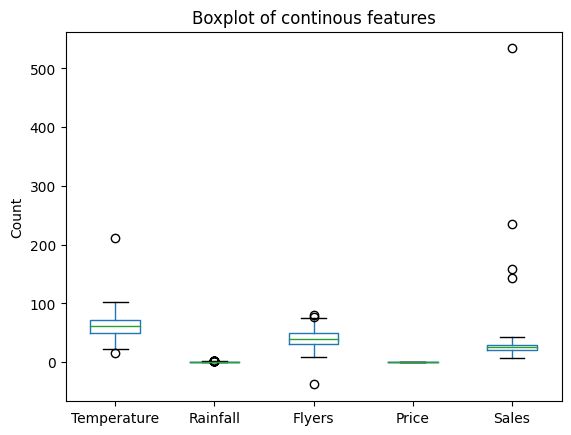

In [17]:
univariate_explore(df[df.describe().columns.tolist()])
df1 = df.copy()
twosig_list=[]
for col in ["Temperature","Rainfall","Flyers"]:
    df1[f"upper_2sig_{col}"] = np.where(df1[col] > df1[col].mean() + (2 * df1[col].std()),1,0)
    df1[f"lower_2sig_{col}"] = np.where(df1[col] < df1[col].mean() - (2 * df1[col].std()),1,0)
    twosig_list.append(f"upper_2sig_{col}")
    twosig_list.append(f"lower_2sig_{col}")



In [18]:
df1[df1[twosig_list].sum(axis=1) > 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,upper_2sig_Temperature,lower_2sig_Temperature,upper_2sig_Rainfall,lower_2sig_Rainfall,upper_2sig_Flyers,lower_2sig_Flyers
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0,0,1,0,0,0
5,1/6/17,Friday,25.3,1.54,23,0.5,11,0,0,1,0,0,0
6,1/7/17,Saturday,32.9,1.54,19,0.5,13,0,0,1,0,0,0
10,1/11/17,Wednesday,32.6,1.54,23,0.5,12,0,0,1,0,0,0
15,1/16/17,Monday,30.6,1.67,24,0.5,12,0,0,1,0,0,0
16,1/17/17,Tuesday,32.2,1.43,26,0.5,14,0,0,1,0,0,0
19,1/20/17,Friday,31.6,1.43,20,0.5,12,0,0,1,0,0,0
23,1/24/17,Tuesday,28.6,1.54,20,0.5,12,0,0,1,0,0,0
41,2/11/17,Saturday,212.0,0.91,35,0.5,21,1,0,0,0,0,0
166,6/16/17,Friday,99.3,0.47,77,0.5,41,1,0,0,0,1,0


Most of these do not make sense to remove, while they are relatively high (or low) most are still typical of the data

# Now use a 3 sigma decision rule to isolate the outliers in the normally distributed columns from lemonade.csv

In [23]:
df.Sales.describe()

count    365.000000
mean      27.865753
std       30.948132
min        7.000000
25%       20.000000
50%       25.000000
75%       30.000000
max      534.000000
Name: Sales, dtype: float64

In [21]:
df1 = df.copy()
twosig_list=[]
for col in ["Temperature","Rainfall","Flyers"]:
    df1[f"upper_3sig_{col}"] = np.where(df1[col] > df1[col].mean() + (3 * df1[col].std()),1,0)
    df1[f"lower_3sig_{col}"] = np.where(df1[col] < df1[col].mean() - (3 * df1[col].std()),1,0)
    twosig_list.append(f"upper_3sig_{col}")
    twosig_list.append(f"lower_3sig_{col}")

df1[df1[twosig_list].sum(axis=1) > 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,upper_3sig_Temperature,lower_3sig_Temperature,upper_3sig_Rainfall,lower_3sig_Rainfall,upper_3sig_Flyers,lower_3sig_Flyers
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0,0,1,0,0,0
15,1/16/17,Monday,30.6,1.67,24,0.5,12,0,0,1,0,0,0
41,2/11/17,Saturday,212.0,0.91,35,0.5,21,1,0,0,0,0,0
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0,0,0,0,0,1
338,12/5/17,Tuesday,22.0,1.82,11,0.5,10,0,0,1,0,0,0
343,12/10/17,Sunday,31.3,1.82,15,0.5,11,0,0,1,0,0,0
364,12/31/17,Sunday,15.1,2.50,9,0.5,7,0,0,1,0,0,0


Most of these do make sense to remove, the data seems to be pretty erroneous    
    - temperature, flyers